In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
# Import the Movies dataset
movies = pd.read_csv("D:\\AI\\data-small\\movies.csv")
movies.head()
# Import the ratings dataset
ratings = pd.read_csv("D:\\AI\\data-small\\ratings.csv")
ratings.head()
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')
print("Số người dùng tham gia rateting: ", len(set(ratings['userId'])))

The dataset contains:  100836  ratings of  9742  movies.
Số người dùng tham gia rateting:  610


In [4]:
# Get all Genres
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))
genre_labels = list(genre_labels)
print("Số lượng genres: ", len(genre_labels))
print(genre_labels)

Số lượng genres:  20
['Romance', 'Sci-Fi', 'Crime', 'Documentary', 'Film-Noir', 'Animation', 'Fantasy', 'Mystery', 'IMAX', 'Children', 'Musical', 'Drama', '(no genres listed)', 'Horror', 'Comedy', 'Thriller', 'Adventure', 'Western', 'Action', 'War']


In [5]:
# Tính mean của mỗi người dùng theo từng thể loại: Romance, Sci-Fi, ...
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2) # Calculate mean: round 2
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings

In [6]:
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi', 'Animation', 'Mystery', 'Fantasy', 'Drama', 'IMAX', 'Documentary', 'Comedy', 'Thriller', 'Action', 'Film-Noir', 'Horror', 'Musical', 'Crime', 'War', '(no genres listed)', 'Adventure', 'Children', 'Western'], ['avg_romance_rating', 'avg_scifi_rating', 'avg_scifi_Animation', 'avg_scifi_Mystery', 'avg_scifi_Fantasy', 'avg_scifi_Drama', 'avg_scifi_IMAX', 'avg_scifi_Documentary', 'avg_scifi_Comedy', 'avg_scifi_Thriller', 'avg_scifi_Action', 'avg_scifi_Film-Noir', 'avg_scifi_Horror', 'avg_scifi_Musical', 'avg_scifi_Crime', 'avg_scifi_War', 'avg_scifi_(no genres listed)', 'avg_scifi_Adventure', 'avg_scifi_Children', 'avg_scifi_Western'])
genre_ratings.fillna(0, inplace=True) # fix if not rating
print(len(genre_ratings.shape))
genre_ratings


2


,avg_romance_rating,avg_scifi_rating,avg_scifi_Animation,avg_scifi_Mystery,avg_scifi_Fantasy,avg_scifi_Drama,avg_scifi_IMAX,avg_scifi_Documentary,avg_scifi_Comedy,avg_scifi_Thriller,avg_scifi_Action,avg_scifi_Film-Noir,avg_scifi_Horror,avg_scifi_Musical,avg_scifi_Crime,avg_scifi_War,avg_scifi_(no genres listed),avg_scifi_Adventure,avg_scifi_Children,avg_scifi_Western
1,4.31,4.22,4.69,4.17,4.30,4.53,0.00,0.00,4.28,4.15,4.32,5.00,3.47,4.68,4.36,4.50,0.0,4.39,4.55,4.29
2,4.50,3.88,0.00,4.00,0.00,3.88,3.75,4.33,4.00,3.70,3.95,0.00,3.00,0.00,3.80,4.50,0.0,4.17,0.00,3.50
3,0.50,4.20,0.50,5.00,3.38,0.75,0.00,0.00,1.00,4.14,3.57,0.00,4.69,0.50,0.50,0.50,0.0,2.73,0.50,0.00
4,3.38,2.83,4.00,3.48,3.68,3.48,3.00,4.00,3.51,3.55,3.32,4.00,4.25,4.00,3.81,3.57,0.0,3.66,3.80,3.80
5,3.09,2.50,4.33,4.00,4.14,3.80,3.67,0.00,3.47,3.56,3.11,0.00,3.00,4.40,3.83,3.33,0.0,3.25,4.11,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.74,3.56,3.71,3.79,3.60,3.79,3.06,3.80,3.57,3.53,3.18,3.81,3.35,3.73,3.65,3.79,0.0,3.50,3.45,3.41
607,3.52,3.25,3.33,4.65,3.57,4.01,5.00,0.00,3.33,4.11,3.72,0.00,4.11,3.60,3.81,4.17,0.0,3.47,3.42,4.00
608,2.89,3.30,3.12,3.55,3.00,3.44,4.00,3.00,2.74,3.54,3.33,3.75,3.32,2.76,3.61,3.58,0.0,3.22,2.46,2.64
609,3.20,3.00,3.00,0.00,3.00,3.37,3.00,3.00,3.29,3.29,3.09,0.00,3.50,0.00,3.50,3.50,0.0,3.20,3.00,4.00


In [7]:
# def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
#     biased_dataset = genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
#     biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
#     biased_dataset = pd.DataFrame(biased_dataset.to_records())
#     return biased_dataset

In [8]:
# def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
#     # biased_dataset = genre_ratings
#     # biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
#     biased_dataset = pd.DataFrame(genre_ratings.to_records())
#     return biased_dataset

In [9]:
# biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)
biased_dataset = genre_ratings
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  610


,avg_romance_rating,avg_scifi_rating,avg_scifi_Animation,avg_scifi_Mystery,avg_scifi_Fantasy,avg_scifi_Drama,avg_scifi_IMAX,avg_scifi_Documentary,avg_scifi_Comedy,avg_scifi_Thriller,avg_scifi_Action,avg_scifi_Film-Noir,avg_scifi_Horror,avg_scifi_Musical,avg_scifi_Crime,avg_scifi_War,avg_scifi_(no genres listed),avg_scifi_Adventure,avg_scifi_Children,avg_scifi_Western
1,4.31,4.22,4.69,4.17,4.30,4.53,0.00,0.00,4.28,4.15,4.32,5.0,3.47,4.68,4.36,4.50,0.0,4.39,4.55,4.29
2,4.50,3.88,0.00,4.00,0.00,3.88,3.75,4.33,4.00,3.70,3.95,0.0,3.00,0.00,3.80,4.50,0.0,4.17,0.00,3.50
3,0.50,4.20,0.50,5.00,3.38,0.75,0.00,0.00,1.00,4.14,3.57,0.0,4.69,0.50,0.50,0.50,0.0,2.73,0.50,0.00
4,3.38,2.83,4.00,3.48,3.68,3.48,3.00,4.00,3.51,3.55,3.32,4.0,4.25,4.00,3.81,3.57,0.0,3.66,3.80,3.80
5,3.09,2.50,4.33,4.00,4.14,3.80,3.67,0.00,3.47,3.56,3.11,0.0,3.00,4.40,3.83,3.33,0.0,3.25,4.11,3.00


In [10]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_romance_rating', 'avg_scifi_rating', 'avg_scifi_Animation', 'avg_scifi_Mystery', 'avg_scifi_Fantasy', 'avg_scifi_Drama', 'avg_scifi_IMAX', 'avg_scifi_Documentary', 'avg_scifi_Comedy', 'avg_scifi_Thriller', 'avg_scifi_Action', 'avg_scifi_Film-Noir', 'avg_scifi_Horror', 'avg_scifi_Musical', 'avg_scifi_Crime', 'avg_scifi_War', 'avg_scifi_(no genres listed)', 'avg_scifi_Adventure', 'avg_scifi_Children', 'avg_scifi_Western']].values

In [11]:
X


array([[4.31, 4.22, 4.69, ..., 4.39, 4.55, 4.29],
       [4.5 , 3.88, 0.  , ..., 4.17, 0.  , 3.5 ],
       [0.5 , 4.2 , 0.5 , ..., 2.73, 0.5 , 0.  ],
       ...,
       [2.89, 3.3 , 3.12, ..., 3.22, 2.46, 2.64],
       [3.2 , 3.  , 3.  , ..., 3.2 , 3.  , 4.  ],
       [3.73, 3.66, 3.9 , ..., 3.71, 3.65, 3.74]])

In [12]:
# Vẽ phân bố các cluster theo mô hình predict theo 2 chiều của 2 đặc trưng đầu tiên là agv scifi và romance
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    

    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)


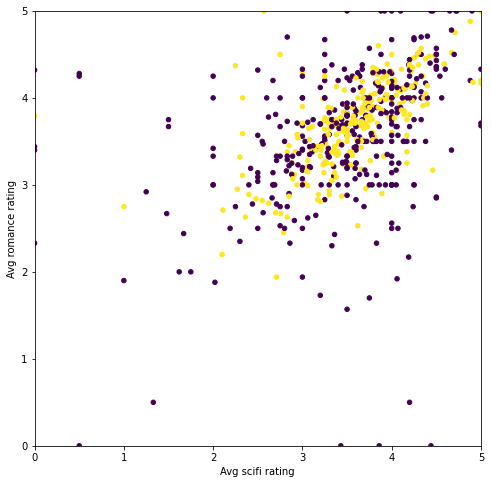

In [13]:
# TODO: Import KMeans
from sklearn.cluster import KMeans

# TODO: Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# TODO: use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Plot
draw_clusters(biased_dataset, predictions)

## Choosing K

In [112]:
# Hàm tính toán score
from sklearn.metrics import mean_squared_error
from math import sqrt
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    # cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data, predictions)]
    # return sum(errors)
    # silhouette đo từ điểm dữ liệu tới điểm trung tâm centroid
    silhouette_avg = silhouette_score(data, predictions)
    # print('Silhouetter Score: %.3f' % silhouette_avg)
    return silhouette_avg
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data, predictions)]
    # rmse = sqrt(sum(errors))
    # return rmse 


In [113]:
# Test với một số giá trị K để tìm giá trị tối ưu
possible_k_values = range(2, len(X), 10)

# Tính toán error value
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

In [114]:
# Liệt kê tất cả các giá trị k đã thử nghiệm, tìm k tối ưu
list(zip(possible_k_values, errors_per_k))

[(2, 0.16280327431254688),
 (12, 0.16641209602893547),
 (22, 0.184574761655658),
 (32, 0.15971434018001454),
 (42, 0.1800526303258724),
 (52, 0.15965294405011626),
 (62, 0.18205971101899293),
 (72, 0.18825502326867438),
 (82, 0.14724178153206724),
 (92, 0.1552596148676051),
 (102, 0.17662922427858105),
 (112, 0.14859601454715907),
 (122, 0.16202219828062578),
 (132, 0.1630295669610377),
 (142, 0.14173551272671278),
 (152, 0.16235617697712865),
 (162, 0.15713687094657197),
 (172, 0.14521948084645736),
 (182, 0.1510042984947701),
 (192, 0.1574272659463309),
 (202, 0.15497748490449945),
 (212, 0.15290667459658203),
 (222, 0.15423358224551859),
 (232, 0.1376464376622483),
 (242, 0.14210862775505187),
 (252, 0.14051760464265198),
 (262, 0.136940875233546),
 (272, 0.13187837181999051),
 (282, 0.12196505501132025),
 (292, 0.11456000871874833),
 (302, 0.1174470316707147),
 (312, 0.11601004591494878),
 (322, 0.10890688364204813),
 (332, 0.0957694340335679),
 (342, 0.08581384316304672),
 (352, 0

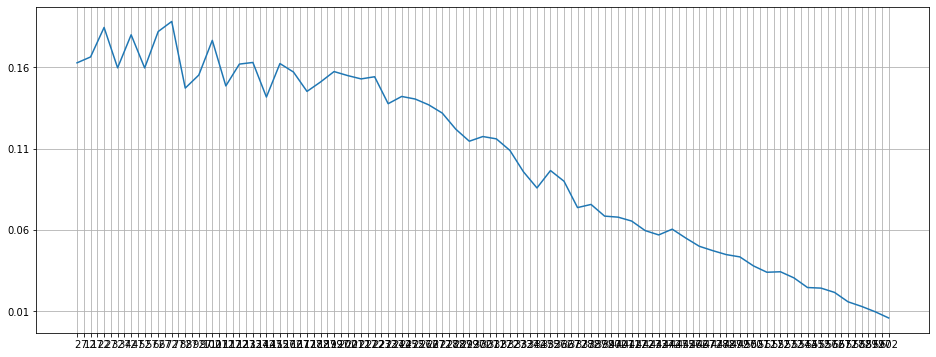

In [115]:
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

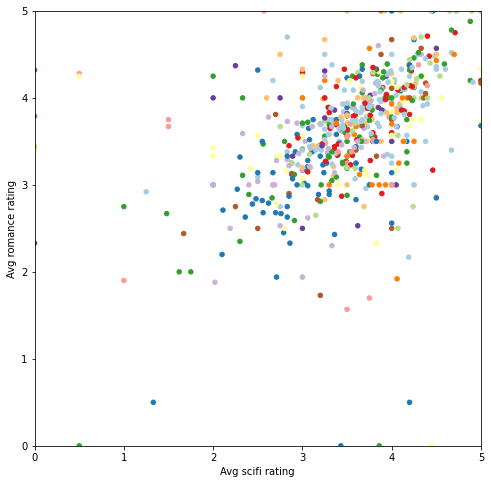

In [40]:
# TODO: Create an instance of KMeans to find seven clusters
kmeans = KMeans(n_clusters=32)

# TODO: use fit_predict to cluster the dataset
predictions = kmeans.fit_predict(X)

# Plot
draw_clusters(biased_dataset, predictions, cmap='Paired')

## Movie-Level Clustering

In [19]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[23:32, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## NaN value gọi là Sparse: tính thưa thớt của dữ liệu

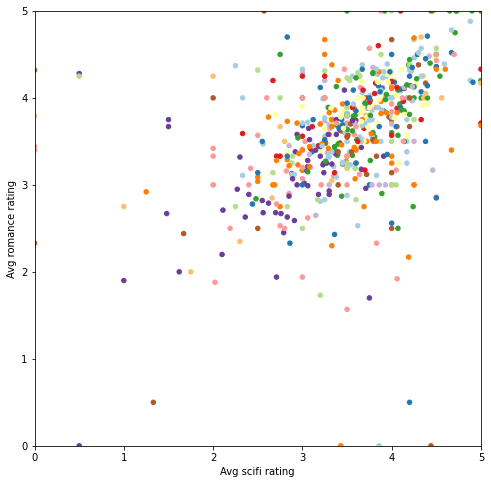

In [153]:
kmeans = KMeans(n_clusters=30)
predictions = kmeans.fit_predict(X)

# Plot
draw_clusters(biased_dataset, predictions, cmap='Paired')

In [35]:
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    # Reverse to match the order of the printed dataframe
    #most_rated_movies_users_selection = most_rated_movies_users_selection.iloc[::-1]
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')

    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])



    plt.show()

In [36]:
def draw_movie_clusters(clustered, max_users, max_movies):
    c=1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most max_users users and max_movies movies per cluster.
        # You can change these values to see more users & movies per cluster
        d = clustered[clustered.group == cluster_id].drop(['index', 'group'], axis=1)
        n_users_in_cluster = d.shape[0]
        
        d = sort_by_rating_density(d, max_movies, max_users)
        
        d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
        d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_movies]
        n_users_in_plot = d.shape[0]
        
        # We're only selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
            print('cluster # {}'.format(cluster_id))
            print('# of users in cluster: {}.'.format(n_users_in_cluster), '# of users in plot: {}'.format(n_users_in_plot))
            fig = plt.figure(figsize=(15,4))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = d.columns.str[:40]

            ax.set_yticks(np.arange(d.shape[0]) , minor=False)
            ax.set_xticks(np.arange(d.shape[1]) , minor=False)

            ax.set_xticklabels(labels, minor=False)
                        
            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=0, vmax=5, aspect='auto')

            ax.set_xlabel('movies')
            ax.set_ylabel('User id')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
            cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', labelbottom='off', labelleft='off') 
            #print('cluster # {} \n(Showing at most {} users and {} movies)'.format(cluster_id, max_users, max_movies))

            plt.show()


            # Let's only show 5 clusters
            # Remove the next three lines if you want to see all the clusters
            # Contribution welcomed: Pythonic way of achieving this
            # c = c+1
            # if c > 6:
            #    break

In [37]:
def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection

In [38]:

def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

In [39]:
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

In [41]:
n_movies_rated = 1000 # Số lượng movies xét
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_n = get_most_rated_movies(user_movie_ratings, n_movies_rated)
print((most_rated_movies_n.shape))

(610, 1000)


In [43]:
# Lưu điểm đánh giá của người thứ index đối với film N, Giá trị NaN là người này chưa từng đánh giá
clustered = pd.concat([most_rated_movies_n.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
print(clustered)

     index  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
0        0                  4.0                               NaN   
1        1                  NaN                               3.0   
2        2                  NaN                               NaN   
3        3                  NaN                               NaN   
4        4                  NaN                               3.0   
..     ...                  ...                               ...   
605    605                  4.0                               3.5   
606    606                  NaN                               5.0   
607    607                  3.0                               4.5   
608    608                  4.0                               4.0   
609    609                  3.0                               3.0   

     Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
0                    3.0                               4.0   
1                    NaN                       

In [50]:
cluster = clustered[clustered.group == 1].drop(['index', 'group'], axis=1)
print("Điểm đánh giá của nhóm người thuộc cluster 1: ")
print(cluster['Forrest Gump (1994)'])
print("Giá trị trung bình: ", cluster['Forrest Gump (1994)'].mean())
cluster = clustered[clustered.group == 14].drop(['index', 'group'], axis=1)
print("Điểm đánh giá của nhóm người cluster 14: ")
print(cluster['Forrest Gump (1994)'])
print("Giá trị trung bình: ", cluster['Forrest Gump (1994)'].mean())
# Một số giá trị xuất hiện NaN do người dùng chưa rate phim này


Điểm đánh giá của nhóm người thuộc cluster 1: 
4      NaN
7      3.0
39     NaN
42     5.0
45     NaN
57     4.0
72     NaN
74     NaN
85     4.0
92     5.0
98     NaN
99     4.0
111    3.5
116    4.0
125    4.0
133    NaN
141    4.0
173    3.0
175    NaN
178    5.0
200    5.0
228    4.0
233    NaN
239    5.0
240    NaN
241    NaN
272    NaN
303    5.0
329    5.0
339    3.0
340    3.5
346    4.0
373    4.0
377    NaN
381    4.5
400    3.5
443    5.0
444    3.0
446    4.0
467    NaN
469    5.0
474    NaN
481    NaN
485    5.0
510    4.5
511    5.0
512    NaN
532    5.0
542    3.0
553    NaN
583    5.0
591    5.0
603    NaN
606    NaN
Name: Forrest Gump (1994), dtype: float64
Giá trị trung bình:  4.25
Điểm đánh giá của nhóm người cluster 14: 
5      5.0
8      NaN
26     5.0
32     5.0
38     NaN
65     5.0
95     NaN
103    4.0
114    NaN
128    NaN
140    4.0
166    3.0
194    NaN
197    5.0
210    4.5
245    3.5
246    5.0
278    3.0
285    4.5
304    4.5
308    NaN
312    NaN
335    

In [58]:
# Với cluster hiện tại là 3
cluster = clustered[clustered.group == 23].drop(['index', 'group'], axis=1)
cluster.mean().head(20).sort_values()[::-1] # số điểm của các film, thử sắp xếp theo số điểm

Schindler's List (1993)                                                           4.700000
Independence Day (a.k.a. ID4) (1996)                                              4.500000
Fight Club (1999)                                                                 4.500000
Shawshank Redemption, The (1994)                                                  4.357143
Usual Suspects, The (1995)                                                        4.250000
Forrest Gump (1994)                                                               4.142857
Seven (a.k.a. Se7en) (1995)                                                       4.083333
Pulp Fiction (1994)                                                               4.055556
Terminator 2: Judgment Day (1991)                                                 4.000000
Apollo 13 (1995)                                                                  4.000000
Silence of the Lambs, The (1991)                                                  3.944444

In [72]:
# Find user id thuộc cluster nào
user_id =  183
clustered[clustered.index==user_id].group[user_id]

23

In [90]:
def recommend_film_with_userid(user_id):
    # Xét với User ID = 1, check 1000 movies
    # user_id =  183 # Tim Cluster sau do lay ratings
    cluster = clustered[clustered.group == clustered[clustered.index==user_id].group[user_id]].drop(['index', 'group'], axis=1)
    user_2_ratings  = cluster.loc[user_id, :]
    # Người dùng này chưa rate một số phim, lấy những film này và tiến hành rate
    user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]
    # Lấy thông tin rating của các movies chưa rate của nguời dùng này
    avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]
    return avg_ratings.sort_values(ascending=False)[:20].index

In [103]:
def recommend_film_with_rating(ratings):
    # Load model
    predictions = kmeans.predict(ratings)
    # Xét với User ID = 1, check 1000 movies
    # user_id =  183 # Tim Cluster sau do lay ratings
    cluster = clustered[clustered.group == predictions].drop(['index', 'group'], axis=1)
    return cluster.mean().head(20).sort_values()[::-1] # số điểm của các film, thử sắp xếp theo số điểm

In [ ]:
# Load model


In [94]:
user_id = input()
print("Hệ thống gợi ý cho user có id =", user_id, " những film sau: \n\n")
films = recommend_film(int(user_id))
for film in films:
    print("- ", film)

Hệ thống gợi ý cho user có id = 12  những film sau: 


-  2001: A Space Odyssey (1968)
-  O Brother, Where Art Thou? (2000)
-  Highlander (1986)
-  Tommy Boy (1995)
-  Caddyshack (1980)
-  Back to the Future (1985)
-  Wolf of Wall Street, The (2013)
-  Godfather: Part II, The (1974)
-  Blazing Saddles (1974)
-  Tombstone (1993)
-  One Flew Over the Cuckoo's Nest (1975)
-  Untouchables, The (1987)
-  This Is Spinal Tap (1984)
-  Fish Called Wanda, A (1988)
-  Airplane! (1980)
-  Maverick (1994)
-  Galaxy Quest (1999)
-  Amadeus (1984)
-  Payback (1999)
-  Unforgiven (1992)


In [106]:
# ['avg_romance_rating', 'avg_scifi_rating', 'avg_scifi_Animation', 'avg_scifi_Mystery', 'avg_scifi_Fantasy', 'avg_scifi_Drama', 'avg_scifi_IMAX', 'avg_scifi_Documentary', 'avg_scifi_Comedy', 'avg_scifi_Thriller', 'avg_scifi_Action', 'avg_scifi_Film-Noir', 'avg_scifi_Horror', 'avg_scifi_Musical', 'avg_scifi_Crime', 'avg_scifi_War', 'avg_scifi_(no genres listed)', 'avg_scifi_Adventure', 'avg_scifi_Children', 'avg_scifi_Western']
X_test = [[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [107]:
predictions = kmeans.predict(X_test)
predictions

array([11, 11, 11])

In [104]:
print(recommend_film_with_rating(X)) 
# Có thể áp dụng với trường hợp người dùng là manh chiếu mới, 
# có thể thích một hoặc một số thể loại thì có thể chấm điểm thể loại là 5 
# và tìm kiếm những bộ phim như v

Shawshank Redemption, The (1994)                                                  4.429022
Fight Club (1999)                                                                 4.272936
Usual Suspects, The (1995)                                                        4.237745
Star Wars: Episode IV - A New Hope (1977)                                         4.231076
Schindler's List (1993)                                                           4.225000
Star Wars: Episode V - The Empire Strikes Back (1980)                             4.215640
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    4.207500
Pulp Fiction (1994)                                                               4.197068
Matrix, The (1999)                                                                4.192446
Forrest Gump (1994)                                                               4.164134
Silence of the Lambs, The (1991)                                                  4.161290

## Test với tập test

In [ ]:
# Load Model


In [ ]:
movies = pd.read_csv("D:\\AI\\dataset-big\\ml-25m\\movies.csv") # duong dan test
movies.head()
# Import the ratings dataset
ratings = pd.read_csv("D:\\AI\\dataset-big\\ml-25m\\ratings.csv") # duong dan test
ratings.head()
# Get Genres of test set
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))
genre_labels = list(genre_labels)
print("Số lượng genres: ", len(genre_labels))
print(genre_labels)
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi', 'Animation', 'Mystery', 'Fantasy', 'Drama', 'IMAX', 'Documentary', 'Comedy', 'Thriller', 'Action', 'Film-Noir', 'Horror', 'Musical', 'Crime', 'War', '(no genres listed)', 'Adventure', 'Children', 'Western'], ['avg_romance_rating', 'avg_scifi_rating', 'avg_scifi_Animation', 'avg_scifi_Mystery', 'avg_scifi_Fantasy', 'avg_scifi_Drama', 'avg_scifi_IMAX', 'avg_scifi_Documentary', 'avg_scifi_Comedy', 'avg_scifi_Thriller', 'avg_scifi_Action', 'avg_scifi_Film-Noir', 'avg_scifi_Horror', 'avg_scifi_Musical', 'avg_scifi_Crime', 'avg_scifi_War', 'avg_scifi_(no genres listed)', 'avg_scifi_Adventure', 'avg_scifi_Children', 'avg_scifi_Western'])
genre_ratings.fillna(0, inplace=True)
print(genre_ratings)
X_test = biased_dataset[['avg_romance_rating', 'avg_scifi_rating', 'avg_scifi_Animation', 'avg_scifi_Mystery', 'avg_scifi_Fantasy', 'avg_scifi_Drama', 'avg_scifi_IMAX', 'avg_scifi_Documentary', 'avg_scifi_Comedy', 'avg_scifi_Thriller', 'avg_scifi_Action', 'avg_scifi_Film-Noir', 'avg_scifi_Horror', 'avg_scifi_Musical', 'avg_scifi_Crime', 'avg_scifi_War', 'avg_scifi_(no genres listed)', 'avg_scifi_Adventure', 'avg_scifi_Children', 'avg_scifi_Western']].values
print("X_test: ", X_test)
predictions = kmeans.predict(X_test)
print(predictions)


In [ ]:
clustered = pd.concat([most_rated_movies_n.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
print(clustered)